In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from collections import defaultdict
from wordcloud import WordCloud 
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from operator import itemgetter
import sys
import gc
#%load_ext autotime

In [2]:
def acquire_data():
    """ 
    
    Returns: dataset uploaded by the user
    
    """
    filepath= input("Enter dataset path: ")
    data=pd.read_csv(filepath)
    return data


In [4]:
#storing the dataset uploaded by the user
df=acquire_data()
df

Enter dataset path: /home/rutvathaker/jupiter_notebook/netflix_titles.csv


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [5]:
category_features = []
threshold = 20
for each in df.columns:
        if df[each].nunique() < threshold:
            category_features.append(each)
count={}        
for each in category_features:
        df[each] = df[each].astype('category')

In [6]:
def get_summary():
        
    """ 
    
    Returns: dictionary with keys as entire dataset metadata
    
    """
    
    
    data = {}
    data["records_shape"] = df.shape[0]
    data["features_shape"]= df.shape[1]
    data["missing"] = pd.isnull(df).sum().sum()
    data["unique"] = df.nunique().sum()
    data["duplicated"] = df.duplicated().sum()
    return(data)

In [7]:
get_summary()

{'records_shape': 8807,
 'features_shape': 12,
 'missing': 4307,
 'unique': 41951,
 'duplicated': 0}

In [8]:
def get_columns_summary():
    
    col= {i:{} for i in df.columns}
    
    for i in df.columns:        
        col[i]["null"] = df[i].isnull().sum() 
        col[i]["dtypes"] = df[i].dtypes
        col[i]["duplicate"] = df[i].duplicated().sum() 
        
        if df[i].dtypes == 'int' or df[i].dtypes == 'float':
            col[i]['mean']= df[i].mean()
            col[i]["median"] = df[i].median()
            col[i]["min"] = df[i].min()
            col[i]["max"] = df[i].max()
            col[i]["std"] = df[i].std()
            col[i]["25%"] = df[i].quantile(q=0.25)
            col[i]["50%"] = df[i].quantile(q=0.5)
            col[i]["75%"] = df[i].quantile(q=0.75)
            col[i]["unique"] = " "
            col[i]["top"] = " "
            col[i]["freq"] = " "
            
        else:   
            col[i]['mean'] = " "
            col[i]['median'] = " "
            col[i]['min'] = " "
            col[i]['max'] = " "
            col[i]["std"] = " "
            col[i]["25%"] = " "
            col[i]["50%"] = " "
            col[i]["75%"] = " "
            col[i]["unique"] = df[i].nunique()
            col[i]["top"] = df[i].value_counts().idxmax()
            col[i]["freq"] = df[i].value_counts().max()
            
            

            
    return(col)

In [9]:
get_columns_summary()

{'show_id': {'null': 0,
  'dtypes': dtype('O'),
  'duplicate': 0,
  'mean': ' ',
  'median': ' ',
  'min': ' ',
  'max': ' ',
  'std': ' ',
  '25%': ' ',
  '50%': ' ',
  '75%': ' ',
  'unique': 8807,
  'top': 's1',
  'freq': 1},
 'type': {'null': 0,
  'dtypes': CategoricalDtype(categories=['Movie', 'TV Show'], ordered=False),
  'duplicate': 8805,
  'mean': ' ',
  'median': ' ',
  'min': ' ',
  'max': ' ',
  'std': ' ',
  '25%': ' ',
  '50%': ' ',
  '75%': ' ',
  'unique': 2,
  'top': 'Movie',
  'freq': 6131},
 'title': {'null': 0,
  'dtypes': dtype('O'),
  'duplicate': 0,
  'mean': ' ',
  'median': ' ',
  'min': ' ',
  'max': ' ',
  'std': ' ',
  '25%': ' ',
  '50%': ' ',
  '75%': ' ',
  'unique': 8807,
  'top': 'Dick Johnson Is Dead',
  'freq': 1},
 'director': {'null': 2634,
  'dtypes': dtype('O'),
  'duplicate': 4278,
  'mean': ' ',
  'median': ' ',
  'min': ' ',
  'max': ' ',
  'std': ' ',
  '25%': ' ',
  '50%': ' ',
  '75%': ' ',
  'unique': 4528,
  'top': 'Rajiv Chilaka',
  'freq

In [10]:
def count_plot():
    
        
    """ 
    
    Returns: dictionary with value count of categorical features to plot count plot
    
    """
    
    category_features = []
    threshold = 20
    for each in df.columns:
        if df[each].nunique() < threshold:
            category_features.append(each)
    count={}
    for each in category_features:
        df[each] = df[each].astype('category')
        count[each]=df[each].value_counts().to_dict()
    return(count)


In [11]:
count_plot()

{'type': {'Movie': 6131, 'TV Show': 2676},
 'rating': {'TV-MA': 3207,
  'TV-14': 2160,
  'TV-PG': 863,
  'R': 799,
  'PG-13': 490,
  'TV-Y7': 334,
  'TV-Y': 307,
  'PG': 287,
  'TV-G': 220,
  'NR': 80,
  'G': 41,
  'TV-Y7-FV': 6,
  'UR': 3,
  'NC-17': 3,
  '74 min': 1,
  '84 min': 1,
  '66 min': 1}}

In [12]:
def box_plot():
    """ 
    
    Returns: dictionary with quartiles for plotting box plot of numeric data
    
    """

    box_values=df.quantile([0.01, 0.25, 0.5, 0.75, 0.99])
    box_values.index=['upper_whisker','Q1','Q2','Q3','lower_whisker']
    box_values=box_values.to_dict()
    
    for k, v in box_values.items():
            
        box_values[k]['IQR'] = box_values.get(k).get('Q3')-box_values.get(k).get('Q1')
        box_values[k]['upper_outlier'] = box_values.get(k).get('Q3')+(1.5*(box_values.get(k).get('Q3')-box_values.get(k).get('Q1')))
        box_values[k]['lower_outlier'] = box_values.get(k).get('Q1')-(1.5*(box_values.get(k).get('Q3')-box_values.get(k).get('Q1')))
        
    return (box_values)

In [13]:
box_plot()

{'release_year': {'upper_whisker': 1976.0,
  'Q1': 2013.0,
  'Q2': 2017.0,
  'Q3': 2019.0,
  'lower_whisker': 2021.0,
  'IQR': 6.0,
  'upper_outlier': 2028.0,
  'lower_outlier': 2004.0}}

In [14]:
def containsNumber(value):
        for character in value:
            if character.isdigit():
                return True
        return False

In [15]:
def word_cloud():
    
    """
    
      Returns: dictionary with words and its frequency for plotting WordClouds
      
      
    """
    df.dropna(how='any',inplace=True)
    words={}
    for val in df.columns:
        if df[val].dtypes == object and type(df[val].values[0])==str:
            words[val]=" ".join(word for word in df[val].values if containsNumber(word)==False and len(word.split())>3)
            
    return(words)


In [16]:
 word_cloud()

{'show_id': '',
 'title': 'The Great British Baking Show Birth of the Dragon InuYasha the Movie: Affections Touching Across Time Naruto Shippuden the Movie: Blood Prison Naruto Shippûden the Movie: Bonds Naruto Shippûden the Movie: The Will of Fire Naruto Shippuden: The Movie Naruto Shippuden: The Movie: The Lost Tower Naruto the Movie: Ninja Clash in the Land of Snow Omo Ghetto: the Saga If I Leave Here Tomorrow: A Film About Lynyrd Skynyrd Blade Runner: The Final Cut Clear and Present Danger Crocodile Dundee in Los Angeles Do the Right Thing El patrón, radiografía de un crimen I Got the Hook Up Janoskians: Untold and Untrue Love Don\'t Cost a Thing Love in a Puff Once Upon a Time in America Same Kind of Different as Me Tears of the Sun The Guns of Navarone Welcome Home Roscoe Jenkins In the Line of Fire EMI: Liya Hai To Chukana Padega King of Boys: The Return of the King Kyaa Kool Hai Hum Kyaa Super Kool Hain Hum Kyo Kii... Main Jhuth Nahin Bolta LSD: Love, Sex Aur Dhokha Mission Ist

In [17]:
category_features = []
for each in df.columns:
        if df[each].dtypes == object and type(df[each].values[0])==str:
            category_features.append(each)
word_len={}
for each in category_features:
        #df[each] = df[each].astype('category')
        #word_len[each]=df[each].value_counts().max()
        word_len[each]=[word for word in df[each].values if containsNumber(word)==False]
        #word_len[each] = {x:word_len[each].count(x) for x in word_len[each]}

In [18]:
word_len

{'show_id': [],
 'title': ['Sankofa',
  'The Great British Baking Show',
  'The Starling',
  'Je Suis Karl',
  'Jeans',
  'Grown Ups',
  'Dark Skies',
  'Paranoia',
  'Birth of the Dragon',
  'Jaws',
  'Jaws: The Revenge',
  'Safe House',
  'Training Day',
  'InuYasha the Movie: Affections Touching Across Time',
  'Naruto Shippuden the Movie: Blood Prison',
  'Naruto Shippûden the Movie: Bonds',
  'Naruto Shippûden the Movie: The Will of Fire',
  'Naruto Shippuden: The Movie',
  'Naruto Shippuden: The Movie: The Lost Tower',
  'Naruto the Movie: Ninja Clash in the Land of Snow',
  'King of Boys',
  'Kate',
  'Omo Ghetto: the Saga',
  'Paradise Hills',
  'Show Dogs',
  'If I Leave Here Tomorrow: A Film About Lynyrd Skynyrd',
  'Angamaly Diaries',
  'A Champion Heart',
  'Anjaam',
  'Bright Star',
  'Dhanak',
  'Gurgaon',
  'In the Cut',
  'Shikara',
  'A Cinderella Story',
  'An Unfinished Life',
  'Blade Runner: The Final Cut',
  'Chappie',
  'Clear and Present Danger',
  'Cliffhanger'

In [19]:
words=word_cloud()
stopwords = nltk.corpus.stopwords.words('english')  
corpus={}
for val in words.keys():
         corpus[val]=[str(word).lower() for word in words[val].split() if str(word).lower() not in stopwords]

In [20]:
corpus

{'show_id': [],
 'title': ['great',
  'british',
  'baking',
  'show',
  'birth',
  'dragon',
  'inuyasha',
  'movie:',
  'affections',
  'touching',
  'across',
  'time',
  'naruto',
  'shippuden',
  'movie:',
  'blood',
  'prison',
  'naruto',
  'shippûden',
  'movie:',
  'bonds',
  'naruto',
  'shippûden',
  'movie:',
  'fire',
  'naruto',
  'shippuden:',
  'movie',
  'naruto',
  'shippuden:',
  'movie:',
  'lost',
  'tower',
  'naruto',
  'movie:',
  'ninja',
  'clash',
  'land',
  'snow',
  'omo',
  'ghetto:',
  'saga',
  'leave',
  'tomorrow:',
  'film',
  'lynyrd',
  'skynyrd',
  'blade',
  'runner:',
  'final',
  'cut',
  'clear',
  'present',
  'danger',
  'crocodile',
  'dundee',
  'los',
  'angeles',
  'right',
  'thing',
  'el',
  'patrón,',
  'radiografía',
  'de',
  'un',
  'crimen',
  'got',
  'hook',
  'janoskians:',
  'untold',
  'untrue',
  'love',
  'cost',
  'thing',
  'love',
  'puff',
  'upon',
  'time',
  'america',
  'kind',
  'different',
  'tears',
  'sun',
  

In [21]:
words_df=pd.DataFrame(corpus.items(), columns=['Features','Words'])

In [22]:
words_df=words_df.explode('Words')

In [23]:
words_df = words_df.dropna(how='any')
words_df

,Features,Words
1,title,great
1,title,british
1,title,baking
1,title,show
1,title,birth
...,...,...
8,description,facing
8,description,fear
8,description,music
8,description,truth


In [24]:
df_dict = {g: d for g, d in words_df.groupby('Features')}

print(df_dict.keys())

dict_keys(['cast', 'country', 'description', 'director', 'listed_in', 'title'])


In [25]:
df_dict = {f'df{i}': d for i, (g, d) in enumerate(words_df.groupby('Features'))}
df_dict.keys()

dict_keys(['df0', 'df1', 'df2', 'df3', 'df4', 'df5'])

In [26]:
df_dict

{'df0':    Features         Words
 3      cast          kofi
 3      cast      ghanaba,
 3      cast    oyafunmike
 3      cast     ogunlano,
 3      cast     alexandra
 ..      ...           ...
 3      cast        rauni,
 3      cast         anita
 3      cast     shabdish,
 3      cast  chittaranjan
 3      cast      tripathy
 
 [86380 rows x 2 columns],
 'df1':    Features       Words
 4   country      united
 4   country     states,
 4   country      ghana,
 4   country     burkina
 4   country       faso,
 ..      ...         ...
 4   country  montenegro
 4   country      united
 4   country        arab
 4   country   emirates,
 4   country      jordan
 
 [2170 rows x 2 columns],
 'df2':        Features     Words
 8   description     photo
 8   description     shoot
 8   description    ghana,
 8   description  american
 8   description     model
 ..          ...       ...
 8   description    facing
 8   description      fear
 8   description     music
 8   description     truth
 

In [27]:
#vec = TfidfVectorizer(stop_words='english')
tfidf={}
for i in df_dict:
    tfidf[i]=dict()
    #print(i)
    vec = TfidfVectorizer(stop_words='english')
    matrix = vec.fit_transform(df_dict[i]['Words'])
    tfidf[i]=(pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names())).T
tfidf
    #idf_df = idf_df.T
    #print(idf_df)
    #tfidf[i]=  tfidf[i].T

/home/rutvathaker/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{'df0':             0      1      2      3      4      5      6      7      8      \
 aabhas        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 aachal        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 aacharekar    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 aadarsh       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 aadhi         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 ...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
 şükran        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 şükrü         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 żulewska      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 żygadło       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 ṣọpẹ          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 
             9      ...  86370  86371  86372  86373  86

In [28]:
for i in tfidf:
    tfidf[i].reset_index(level=0, inplace=True)
    tfidf[i].rename({'index': 'Words'}, axis=1, inplace=True)

In [29]:
tfidf

{'df0':             Words    0    1    2    3    4    5    6    7    8  ...  86370  \
 0          aabhas  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
 1          aachal  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
 2      aacharekar  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
 3         aadarsh  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
 4           aadhi  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
 ...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
 24012      şükran  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
 24013       şükrü  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
 24014    żulewska  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
 24015     żygadło  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
 24016        ṣọpẹ  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
 
        86371  86372  86373  86374  86375  

In [30]:
tfidf['df3']

,Words,0,1,2,3,4,5,6,7,8,...,2415,2416,2417,2418,2419,2420,2421,2422,2423,2424
0,aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,abbas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,abdullah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,abhijit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abhinav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,àlex,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1547,álex,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1548,éric,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1549,ömer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#X_train={}
X_train = defaultdict(list)
for i in tfidf:
    #X_train = defaultdict(list)
    sc_X = StandardScaler()
    X_train[i].append( sc_X.fit_transform(tfidf[i].iloc[:, 1:]))
    gc.isenabled()

In [34]:
wcss = []
for i in range(1, 40, 2):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
    print('\rProgress: %d' % i, end='')
    sys.stdout.flush()

Progress: 39

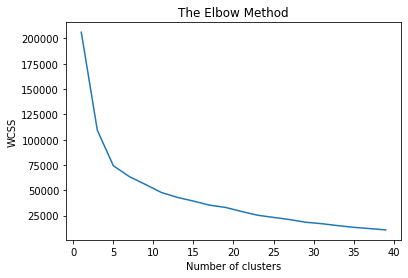

In [30]:
plt.plot(range(1, 40, 2), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

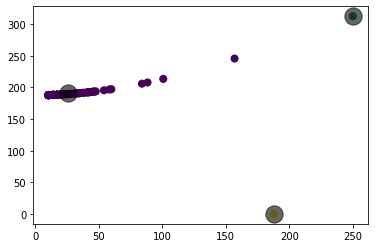

In [31]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_transform(X_train)
fitted=kmeans.fit(y_kmeans)
prediction=kmeans.predict(y_kmeans)
plt.scatter(y_kmeans[:, 0], y_kmeans[:, 1],c=prediction,s=50 , cmap='viridis')
centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6)


In [39]:
#for i in tfidf:
clusters = kmeans.labels_
tfidf['df3']['clusters']=clusters

In [44]:
#for i in tfidf:
tfidf['df3']=tfidf['df3'].loc[:,['Words','clusters']]
tfidf['df3'].sort_values('clusters')

,Words,clusters
493,goldberg,0
467,gaur,1
412,farrelly,2
1034,ojha,3
1033,odendaal,3
...,...,...
629,javier,34
1493,wells,35
781,kwan,36
323,david,37


In [50]:
#for i tfidf:
for j in range(0,3):
    word=" ".join(line for line in (tfidf[tfidf['clusters']==j].Words.values))
    WC = WordCloud(max_font_size=50, max_words=30, background_color="White").generate(word)
    print('clusters no.{}'.format(j))
    plt.imshow(WC, interpolation = 'bilinear') 
    plt.axis('off')
    plt.show()
    i+=1



TypeError: unhashable type: 'Series'

In [26]:
outdflist =[]
# for each index beyond first: 
for rows in idf_df.index.unique():
    # create a subdf with desired columns:
    subdf = words_df.loc[rows]
    outdflist.append(subdf)
    #print(outdflist)
# to view all dataframes created: 
for dt in outdflist:
    print(dt)

Features    show_id
Words           NaN
Name: 0, dtype: object
   Features    Words
1     title    great
1     title  british
1     title   baking
1     title     show
1     title    birth
..      ...      ...
1     title     life
1     title     mess
1     title    zohan
1     title   yours,
1     title     mine

[5624 rows x 2 columns]
    Features      Words
2   director        jjc
2   director    skillz,
2   director      funke
2   director   akindele
2   director     george
..       ...        ...
2   director     clark,
2   director    roxanne
2   director  benjamin,
2   director      karyn
2   director     kusama

[2425 rows x 2 columns]
   Features         Words
3      cast          kofi
3      cast      ghanaba,
3      cast    oyafunmike
3      cast     ogunlano,
3      cast     alexandra
..      ...           ...
3      cast        rauni,
3      cast         anita
3      cast     shabdish,
3      cast  chittaranjan
3      cast      tripathy

[86380 rows x 2 columns]
   Featur

In [199]:
outdflist =[]
# for each index beyond first: 
for rows in idf_df.index:
    print(rows)
    # create a subdf with desired columns:
    subdfs = idf_df.loc[rows]
    outdflist.append(subdfs)
    #print(outdflist)
# to view all dataframes created: 
for dft in outdflist:
    print(dft)

aagey
aane
aapke
aardman
aata
abcd
abdullah
abrazo
abroad
abuja
academy
acapulco
ace
act
action
actun
adam
aditi
admissions
ado
advent
adventure
adventures
ae
affections
afraid
agatha
age
agency
aggretsuko
agustín
ahanna
ai
aimer
air
aisa
ajab
akaal
akbar
al
alan
alaska
albert
albion
alcohol
alejandro
alex
alexandria
alexis
ali
alice
alien
aliens
alive
allen
allergic
alligator
almaraz
alonzo
alpha
althorp
alvida
amandla
amar
amazing
amelia
amer
america
american
amor
amstell
amulet
amy
anaconda
anarchy
andre
andré
andy
angeles
angelou
angels
ani
animal
animals
animated
animation
anitta
anjelah
ankur
annabelle
annefrank
ansari
ant
antar
anthony
anymore
anécdota
apatow
apex
apocalypse
app
april
arango
arc
architecture
arctic
arguing
ari
ariana
aristarán
ariya
arjun
ark
arlo
armistead
armstrong
army
arnold
arora
arrest
arsenio
art
arts
aruna
asa
asado
asfalto
asgard
asia
asian
assassin
assassinated
assistant
asura
así
ate
athenaeum
atlas
attacking
attenborough
au
aucoin
auntie
aur
aurr
aus

livin
living
liya
lizards
lizzie
ll
llamas
llanto
lloyd
lo
loathing
lobby
lock
lockdown
locked
lokillo
lola
lolle
london
long
longer
look
loose
lopez
lorai
lorax
lord
loren
los
loser
losing
lost
lot
love
loved
lover
lovers
loving
low
lower
lsd
lu
lucas
luccas
lucha
luck
lucky
luff
luke
lunch
luque
luther
luv
lycans
lying
lynne
lynyrd
líquidos
maal
mac
macchli
macdonald
machine
mad
madagascar
madame
madden
maddman
madigan
madison
madman
madness
maggie
magic
magnificent
magnolia
maheswara
mahlangu
maili
main
maine
majesty
make
makes
making
mala
malala
malena
malibu
mall
maluku
mamá
man
manager
mancha
manchester
mande
mandela
mandy
mangatiti
manhattan
maniscalco
mankind
mann
manolo
manorama
mantra
map
maps
marc
marco
maria
mariah
marilyn
maron
married
mars
marsh
martial
martin
marvel
mary
masameer
mask
massacre
massively
master
masters
maternity
matte
mattel
maupin
maurício
mauthausen
maximum
maya
mayam
mayan
maybe
maze
mckenna
meaning
meatballs
medhi
meena
meets
mega
megaforce
megatomb
m

Name: afraid, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: agatha, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: age, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: agency, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: aggretsuko, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: agustín, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: bobby, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: body, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: bolta, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: bolton, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: boltoy, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0

Name: deon, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: der, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: deray, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: des, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: desert, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: deserted, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620 

Name: flying, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: fog, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: folk, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: folsom, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: foo, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: fools, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620   

Name: hunt, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: hunter, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: hunting, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: hurricane, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: hustle, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: huttsgalor, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619

Name: legalize, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: legend, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: legendary, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: legends, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: lego, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: lekhe, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619   

Name: mission, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: mitfords, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: mittal, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: mitzvah, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: mixed, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: mo, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0

Name: polo, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: pong, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: pongo, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: ponoc, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: pontianak, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: pony, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
562

Name: scaris, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: scarlatto, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: scarrier, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: schitt, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: schmidt, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: schneider, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5

Name: swan, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: sweat, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: sweeney, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: sweet, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: switch, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: switched, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0

Name: vous, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: vs, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: vulcan, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: vyaar, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: vyakti, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620    0.0
5621    0.0
5622    0.0
5623    0.0
Name: wales, Length: 5624, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5619    0.0
5620  